# kNN Titration
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate the effect of `k` parameter on preservation of kNN graphs from high to low dimensional space after dimensionality reduction.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse colon scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse colon, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# read in Macosko colon data
retina = sc.read_text('../inputs/GSM1626793_P14retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [4]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [6]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [7]:
# create dictionaries for dumping results into
final_kNN_stats = {
    'PCA':{'retina':{'k':{}, 'Knn Pres.':{}}, 'colon':{'k':{}, 'Knn Pres.':{}}},
    't-SNE':{'retina':{'k':{}, 'Knn Pres.':{}}, 'colon':{'k':{}, 'Knn Pres.':{}}},
    'UMAP':{'retina':{'k':{}, 'Knn Pres.':{}}, 'colon':{'k':{}, 'Knn Pres.':{}}}
                  }

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data.

In [8]:
retina.X = retina.layers['arcsinh_norm'] # use arcsinh-normalized counts
sc.tl.pca(retina, use_highly_variable=False, n_comps=2) # perform 2-component PCA

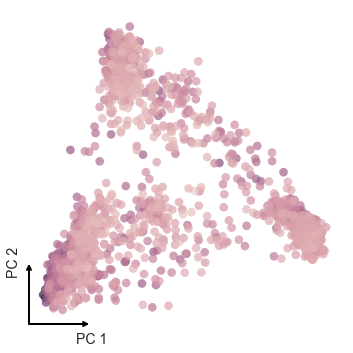

In [10]:
DR_plot(dim_name='PC').plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

In [11]:
# save distance matrix in AnnData object for easy access
retina.uns['X_distance'] = cdist(retina.X, retina.X)

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['X_distance'], 5, retina, save_rep='X_knn_5') # 5 neighbors
knn_graph(retina.uns['X_distance'], 10, retina, save_rep='X_knn_10') # 10 neighbors
knn_graph(retina.uns['X_distance'], 30, retina, save_rep='X_knn_30') # 30 neighbors
knn_graph(retina.uns['X_distance'], 70, retina, save_rep='X_knn_70') # 70 neighbors
knn_graph(retina.uns['X_distance'], 100, retina, save_rep='X_knn_100') # 100 neighbors
knn_graph(retina.uns['X_distance'], 200, retina, save_rep='X_knn_200') # 200 neighbors
knn_graph(retina.uns['X_distance'], 500, retina, save_rep='X_knn_500') # 500 neighbors
knn_graph(retina.uns['X_distance'], 1000, retina, save_rep='X_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [12]:
# save distance matrix in AnnData object for easy access
retina.uns['PCA2_distance'] = cdist(retina.obsm['X_pca'], retina.obsm['X_pca'])

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['PCA2_distance'], 5, retina, save_rep='PCA2_knn_5') # 5 neighbors
knn_graph(retina.uns['PCA2_distance'], 10, retina, save_rep='PCA2_knn_10') # 10 neighbors
knn_graph(retina.uns['PCA2_distance'], 30, retina, save_rep='PCA2_knn_30') # 30 neighbors
knn_graph(retina.uns['PCA2_distance'], 70, retina, save_rep='PCA2_knn_70') # 70 neighbors
knn_graph(retina.uns['PCA2_distance'], 100, retina, save_rep='PCA2_knn_100') # 100 neighbors
knn_graph(retina.uns['PCA2_distance'], 200, retina, save_rep='PCA2_knn_200') # 200 neighbors
knn_graph(retina.uns['PCA2_distance'], 500, retina, save_rep='PCA2_knn_500') # 500 neighbors
knn_graph(retina.uns['PCA2_distance'], 1000, retina, save_rep='PCA2_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [13]:
colon.X = colon.layers['arcsinh_norm'] # move arcsinh-normalized values into default slot
sc.tl.pca(colon, use_highly_variable=False, n_comps=2) # perform 2-component PCA

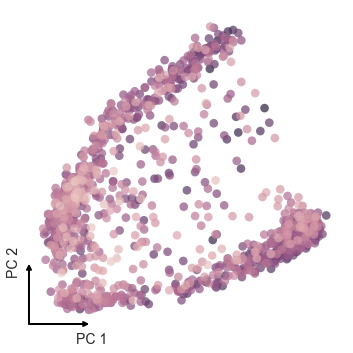

In [14]:
DR_plot(dim_name='PC').plot(colon.obsm['X_pca'], color=colon.obs['log1p_total_counts'])

In [15]:
# save distance matrix in AnnData object for easy access
colon.uns['X_distance'] = cdist(colon.X, colon.X)

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['X_distance'], 5, colon, save_rep='X_knn_5') # 5 neighbors
knn_graph(colon.uns['X_distance'], 10, colon, save_rep='X_knn_10') # 10 neighbors
knn_graph(colon.uns['X_distance'], 30, colon, save_rep='X_knn_30') # 30 neighbors
knn_graph(colon.uns['X_distance'], 70, colon, save_rep='X_knn_70') # 70 neighbors
knn_graph(colon.uns['X_distance'], 100, colon, save_rep='X_knn_100') # 100 neighbors
knn_graph(colon.uns['X_distance'], 200, colon, save_rep='X_knn_200') # 200 neighbors
knn_graph(colon.uns['X_distance'], 500, colon, save_rep='X_knn_500') # 500 neighbors
knn_graph(colon.uns['X_distance'], 1000, colon, save_rep='X_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [16]:
# save distance matrix in AnnData object for easy access
colon.uns['PCA2_distance'] = cdist(colon.obsm['X_pca'], colon.obsm['X_pca'])

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['PCA2_distance'], 5, colon, save_rep='PCA2_knn_5') # 5 neighbors
knn_graph(colon.uns['PCA2_distance'], 10, colon, save_rep='PCA2_knn_10') # 10 neighbors
knn_graph(colon.uns['PCA2_distance'], 30, colon, save_rep='PCA2_knn_30') # 30 neighbors
knn_graph(colon.uns['PCA2_distance'], 70, colon, save_rep='PCA2_knn_70') # 70 neighbors
knn_graph(colon.uns['PCA2_distance'], 100, colon, save_rep='PCA2_knn_100') # 100 neighbors
knn_graph(colon.uns['PCA2_distance'], 200, colon, save_rep='PCA2_knn_200') # 200 neighbors
knn_graph(colon.uns['PCA2_distance'], 500, colon, save_rep='PCA2_knn_500') # 500 neighbors
knn_graph(colon.uns['PCA2_distance'], 1000, colon, save_rep='PCA2_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [18]:
retina_tSNE = pd.read_csv('outputs/retina_tSNE.csv', header=None)

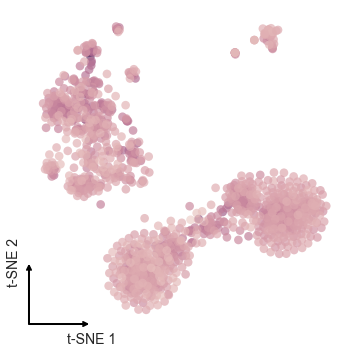

In [19]:
retina.obsm['X_tsne'] = np.ascontiguousarray(retina_tSNE)
DR_plot(dim_name='t-SNE').plot(retina.obsm['X_tsne'], color=retina.obs['log1p_total_counts'])

In [21]:
# save distance matrix in AnnData object for easy access
retina.uns['tsne_distance'] = cdist(retina.obsm['X_tsne'], retina.obsm['X_tsne'])

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['tsne_distance'], 5, retina, save_rep='tsne_knn_5') # 5 neighbors
knn_graph(retina.uns['tsne_distance'], 10, retina, save_rep='tsne_knn_10') # 10 neighbors
knn_graph(retina.uns['tsne_distance'], 30, retina, save_rep='tsne_knn_30') # 30 neighbors
knn_graph(retina.uns['tsne_distance'], 70, retina, save_rep='tsne_knn_70') # 70 neighbors
knn_graph(retina.uns['tsne_distance'], 100, retina, save_rep='tsne_knn_100') # 100 neighbors
knn_graph(retina.uns['tsne_distance'], 200, retina, save_rep='tsne_knn_200') # 200 neighbors
knn_graph(retina.uns['tsne_distance'], 500, retina, save_rep='tsne_knn_500') # 500 neighbors
knn_graph(retina.uns['tsne_distance'], 1000, retina, save_rep='tsne_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [23]:
colon_tSNE = pd.read_csv('outputs/colon_tSNE.csv', header=None)

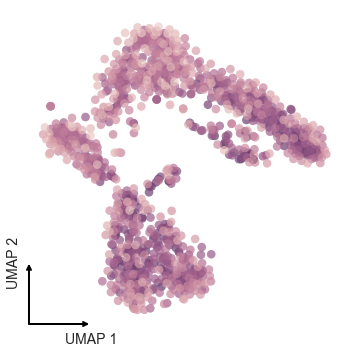

In [24]:
colon.obsm['X_tsne'] = np.ascontiguousarray(colon_tSNE)
DR_plot(dim_name='UMAP').plot(colon.obsm['X_tsne'], color=colon.obs['log1p_total_counts'])

In [25]:
# save distance matrix in AnnData object for easy access
colon.uns['tsne_distance'] = cdist(colon.obsm['X_tsne'], colon.obsm['X_tsne'])

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['tsne_distance'], 5, colon, save_rep='tsne_knn_5') # 5 neighbors
knn_graph(colon.uns['tsne_distance'], 10, colon, save_rep='tsne_knn_10') # 10 neighbors
knn_graph(colon.uns['tsne_distance'], 30, colon, save_rep='tsne_knn_30') # 30 neighbors
knn_graph(colon.uns['tsne_distance'], 70, colon, save_rep='tsne_knn_70') # 70 neighbors
knn_graph(colon.uns['tsne_distance'], 100, colon, save_rep='tsne_knn_100') # 100 neighbors
knn_graph(colon.uns['tsne_distance'], 200, colon, save_rep='tsne_knn_200') # 200 neighbors
knn_graph(colon.uns['tsne_distance'], 500, colon, save_rep='tsne_knn_500') # 500 neighbors
knn_graph(colon.uns['tsne_distance'], 1000, colon, save_rep='tsne_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [26]:
retina_umap = pd.read_csv('outputs/retina_UMAP.csv', header=None)

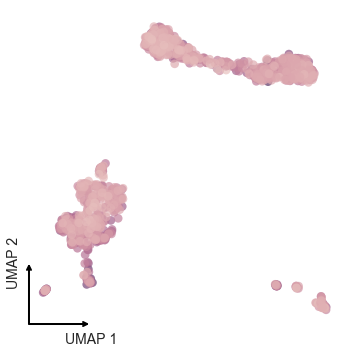

In [27]:
retina.obsm['X_umap'] = np.ascontiguousarray(retina_umap)
DR_plot(dim_name='UMAP').plot(retina.obsm['X_umap'], color=retina.obs['log1p_total_counts'])

In [28]:
# save distance matrix in AnnData object for easy access
retina.uns['umap_distance'] = cdist(retina.obsm['X_umap'], retina.obsm['X_umap'])

# calculate simple binary knn graph the distance matrix above
knn_graph(retina.uns['umap_distance'], 5, retina, save_rep='umap_knn_5') # 5 neighbors
knn_graph(retina.uns['umap_distance'], 10, retina, save_rep='umap_knn_10') # 10 neighbors
knn_graph(retina.uns['umap_distance'], 30, retina, save_rep='umap_knn_30') # 30 neighbors
knn_graph(retina.uns['umap_distance'], 70, retina, save_rep='umap_knn_70') # 70 neighbors
knn_graph(retina.uns['umap_distance'], 100, retina, save_rep='umap_knn_100') # 100 neighbors
knn_graph(retina.uns['umap_distance'], 200, retina, save_rep='umap_knn_200') # 200 neighbors
knn_graph(retina.uns['umap_distance'], 500, retina, save_rep='umap_knn_500') # 500 neighbors
knn_graph(retina.uns['umap_distance'], 1000, retina, save_rep='umap_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [29]:
colon_umap = pd.read_csv('outputs/colon_UMAP.csv', header=None)

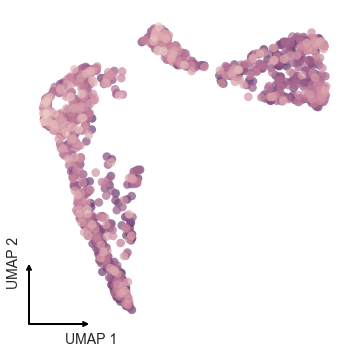

In [30]:
colon.obsm['X_umap'] = np.ascontiguousarray(colon_umap)
DR_plot(dim_name='UMAP').plot(colon.obsm['X_umap'], color=colon.obs['log1p_total_counts'])

In [31]:
# save distance matrix in AnnData object for easy access
colon.uns['umap_distance'] = cdist(colon.obsm['X_umap'], colon.obsm['X_umap'])

# calculate simple binary knn graph the distance matrix above
knn_graph(colon.uns['umap_distance'], 5, colon, save_rep='umap_knn_5') # 5 neighbors
knn_graph(colon.uns['umap_distance'], 10, colon, save_rep='umap_knn_10') # 10 neighbors
knn_graph(colon.uns['umap_distance'], 30, colon, save_rep='umap_knn_30') # 30 neighbors
knn_graph(colon.uns['umap_distance'], 70, colon, save_rep='umap_knn_70') # 70 neighbors
knn_graph(colon.uns['umap_distance'], 100, colon, save_rep='umap_knn_100') # 100 neighbors
knn_graph(colon.uns['umap_distance'], 200, colon, save_rep='umap_knn_200') # 200 neighbors
knn_graph(colon.uns['umap_distance'], 500, colon, save_rep='umap_knn_500') # 500 neighbors
knn_graph(colon.uns['umap_distance'], 1000, colon, save_rep='umap_knn_1000') # 1000 neighbors

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [32]:
# PCA retina
final_kNN_stats['PCA']['retina']['k']['PCA 5'] = 5
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 5'] = knn_preservation(pre=retina.uns['X_knn_5'], post=retina.uns['PCA2_knn_5'])
final_kNN_stats['PCA']['retina']['k']['PCA 10'] = 10
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 10'] = knn_preservation(pre=retina.uns['X_knn_10'], post=retina.uns['PCA2_knn_10'])
final_kNN_stats['PCA']['retina']['k']['PCA 30'] = 30
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 30'] = knn_preservation(pre=retina.uns['X_knn_30'], post=retina.uns['PCA2_knn_30'])
final_kNN_stats['PCA']['retina']['k']['PCA 70'] = 70
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 70'] = knn_preservation(pre=retina.uns['X_knn_70'], post=retina.uns['PCA2_knn_70'])
final_kNN_stats['PCA']['retina']['k']['PCA 100'] = 100
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 100'] = knn_preservation(pre=retina.uns['X_knn_100'], post=retina.uns['PCA2_knn_100'])
final_kNN_stats['PCA']['retina']['k']['PCA 200'] = 200
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 200'] = knn_preservation(pre=retina.uns['X_knn_200'], post=retina.uns['PCA2_knn_200'])
final_kNN_stats['PCA']['retina']['k']['PCA 500'] = 500
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 500'] = knn_preservation(pre=retina.uns['X_knn_500'], post=retina.uns['PCA2_knn_500'])
final_kNN_stats['PCA']['retina']['k']['PCA 1000'] = 1000
final_kNN_stats['PCA']['retina']['Knn Pres.']['PCA 1000'] = knn_preservation(pre=retina.uns['X_knn_1000'], post=retina.uns['PCA2_knn_1000'])

In [33]:
# PCA colon
final_kNN_stats['PCA']['colon']['k']['PCA 5'] = 5
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 5'] = knn_preservation(pre=colon.uns['X_knn_5'], post=colon.uns['PCA2_knn_5'])
final_kNN_stats['PCA']['colon']['k']['PCA 10'] = 10
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 10'] = knn_preservation(pre=colon.uns['X_knn_10'], post=colon.uns['PCA2_knn_10'])
final_kNN_stats['PCA']['colon']['k']['PCA 30'] = 30
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 30'] = knn_preservation(pre=colon.uns['X_knn_30'], post=colon.uns['PCA2_knn_30'])
final_kNN_stats['PCA']['colon']['k']['PCA 70'] = 70
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 70'] = knn_preservation(pre=colon.uns['X_knn_70'], post=colon.uns['PCA2_knn_70'])
final_kNN_stats['PCA']['colon']['k']['PCA 100'] = 100
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 100'] = knn_preservation(pre=colon.uns['X_knn_100'], post=colon.uns['PCA2_knn_100'])
final_kNN_stats['PCA']['colon']['k']['PCA 200'] = 200
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 200'] = knn_preservation(pre=colon.uns['X_knn_200'], post=colon.uns['PCA2_knn_200'])
final_kNN_stats['PCA']['colon']['k']['PCA 500'] = 500
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 500'] = knn_preservation(pre=colon.uns['X_knn_500'], post=colon.uns['PCA2_knn_500'])
final_kNN_stats['PCA']['colon']['k']['PCA 1000'] = 1000
final_kNN_stats['PCA']['colon']['Knn Pres.']['PCA 1000'] = knn_preservation(pre=colon.uns['X_knn_1000'], post=colon.uns['PCA2_knn_1000'])

In [34]:
# t-SNE retina
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 5'] = 5
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 5'] = knn_preservation(pre=retina.uns['X_knn_5'], post=retina.uns['tsne_knn_5'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 10'] = 10
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 10'] = knn_preservation(pre=retina.uns['X_knn_10'], post=retina.uns['tsne_knn_10'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 30'] = 30
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 30'] = knn_preservation(pre=retina.uns['X_knn_30'], post=retina.uns['tsne_knn_30'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 70'] = 70
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 70'] = knn_preservation(pre=retina.uns['X_knn_70'], post=retina.uns['tsne_knn_70'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 100'] = 100
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 100'] = knn_preservation(pre=retina.uns['X_knn_100'], post=retina.uns['tsne_knn_100'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 200'] = 200
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 200'] = knn_preservation(pre=retina.uns['X_knn_200'], post=retina.uns['tsne_knn_200'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 500'] = 500
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 500'] = knn_preservation(pre=retina.uns['X_knn_500'], post=retina.uns['tsne_knn_500'])
final_kNN_stats['t-SNE']['retina']['k']['t-SNE 1000'] = 1000
final_kNN_stats['t-SNE']['retina']['Knn Pres.']['t-SNE 1000'] = knn_preservation(pre=retina.uns['X_knn_1000'], post=retina.uns['tsne_knn_1000'])

In [35]:
# t-SNE colon
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 5'] = 5
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 5'] = knn_preservation(pre=colon.uns['X_knn_5'], post=colon.uns['tsne_knn_5'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 10'] = 10
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 10'] = knn_preservation(pre=colon.uns['X_knn_10'], post=colon.uns['tsne_knn_10'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 30'] = 30
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 30'] = knn_preservation(pre=colon.uns['X_knn_30'], post=colon.uns['tsne_knn_30'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 70'] = 70
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 70'] = knn_preservation(pre=colon.uns['X_knn_70'], post=colon.uns['tsne_knn_70'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 100'] = 100
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 100'] = knn_preservation(pre=colon.uns['X_knn_100'], post=colon.uns['tsne_knn_100'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 200'] = 200
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 200'] = knn_preservation(pre=colon.uns['X_knn_200'], post=colon.uns['tsne_knn_200'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 500'] = 500
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 500'] = knn_preservation(pre=colon.uns['X_knn_500'], post=colon.uns['tsne_knn_500'])
final_kNN_stats['t-SNE']['colon']['k']['t-SNE 1000'] = 1000
final_kNN_stats['t-SNE']['colon']['Knn Pres.']['t-SNE 1000'] = knn_preservation(pre=colon.uns['X_knn_1000'], post=colon.uns['tsne_knn_1000'])

In [36]:
# UMAP retina
final_kNN_stats['UMAP']['retina']['k']['UMAP 5'] = 5
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 5'] = knn_preservation(pre=retina.uns['X_knn_5'], post=retina.uns['umap_knn_5'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 10'] = 10
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 10'] = knn_preservation(pre=retina.uns['X_knn_10'], post=retina.uns['umap_knn_10'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 30'] = 30
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 30'] = knn_preservation(pre=retina.uns['X_knn_30'], post=retina.uns['umap_knn_30'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 70'] = 70
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 70'] = knn_preservation(pre=retina.uns['X_knn_70'], post=retina.uns['umap_knn_70'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 100'] = 100
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 100'] = knn_preservation(pre=retina.uns['X_knn_100'], post=retina.uns['umap_knn_100'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 200'] = 200
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 200'] = knn_preservation(pre=retina.uns['X_knn_200'], post=retina.uns['umap_knn_200'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 500'] = 500
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 500'] = knn_preservation(pre=retina.uns['X_knn_500'], post=retina.uns['umap_knn_500'])
final_kNN_stats['UMAP']['retina']['k']['UMAP 1000'] = 1000
final_kNN_stats['UMAP']['retina']['Knn Pres.']['UMAP 1000'] = knn_preservation(pre=retina.uns['X_knn_1000'], post=retina.uns['umap_knn_1000'])

In [37]:
# UMAP colon
final_kNN_stats['UMAP']['colon']['k']['UMAP 5'] = 5
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 5'] = knn_preservation(pre=colon.uns['X_knn_5'], post=colon.uns['umap_knn_5'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 10'] = 10
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 10'] = knn_preservation(pre=colon.uns['X_knn_10'], post=colon.uns['umap_knn_10'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 30'] = 30
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 30'] = knn_preservation(pre=colon.uns['X_knn_30'], post=colon.uns['umap_knn_30'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 70'] = 70
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 70'] = knn_preservation(pre=colon.uns['X_knn_70'], post=colon.uns['umap_knn_70'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 100'] = 100
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 100'] = knn_preservation(pre=colon.uns['X_knn_100'], post=colon.uns['umap_knn_100'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 200'] = 200
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 200'] = knn_preservation(pre=colon.uns['X_knn_200'], post=colon.uns['umap_knn_200'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 500'] = 500
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 500'] = knn_preservation(pre=colon.uns['X_knn_500'], post=colon.uns['umap_knn_500'])
final_kNN_stats['UMAP']['colon']['k']['UMAP 1000'] = 1000
final_kNN_stats['UMAP']['colon']['Knn Pres.']['UMAP 1000'] = knn_preservation(pre=colon.uns['X_knn_1000'], post=colon.uns['umap_knn_1000'])

---
### Aggregate summary metrics

In [38]:
retina_PCA_sum = pd.DataFrame(final_kNN_stats['PCA']['retina'])
retina_PCA_sum = retina_PCA_sum.sort_values(by='k')
retina_PCA_sum = retina_PCA_sum.reindex(['k','Knn Pres.'], axis=1)
#retina_PCA_sum.to_csv('retina_PCA_kNNtitration.csv')

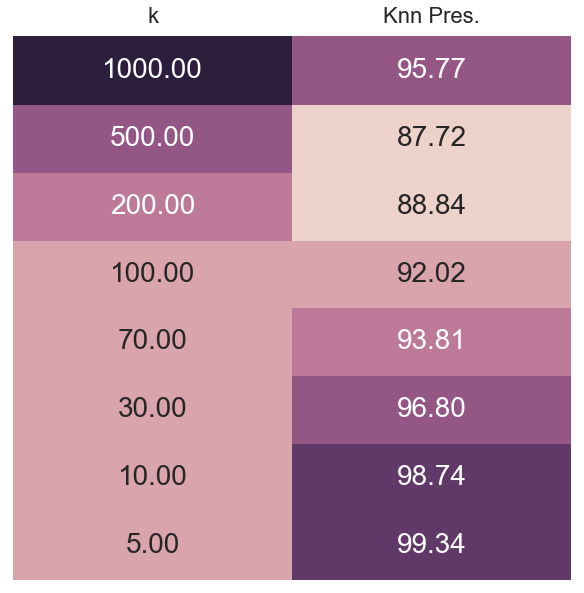

In [39]:
retina_norm=(retina_PCA_sum-retina_PCA_sum.mean())/retina_PCA_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_PCA_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/retina_PCA_kNNtitration.png', transparent=True, bbox_inches='tight')

In [40]:
retina_tSNE_sum = pd.DataFrame(final_kNN_stats['t-SNE']['retina'])
retina_tSNE_sum = retina_tSNE_sum.sort_values(by='k')
retina_tSNE_sum = retina_tSNE_sum.reindex(['k','Knn Pres.'], axis=1)
#retina_tSNE_sum.to_csv('retina_tSNE_kNNtitration.csv')

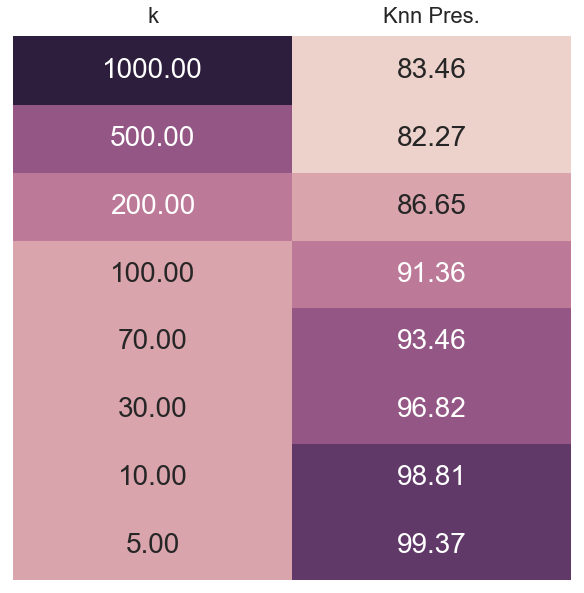

In [41]:
retina_norm=(retina_tSNE_sum-retina_tSNE_sum.mean())/retina_tSNE_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_tSNE_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/retina_tSNE_kNNtitration.png', transparent=True, bbox_inches='tight')

In [42]:
retina_UMAP_sum = pd.DataFrame(final_kNN_stats['UMAP']['retina'])
retina_UMAP_sum = retina_UMAP_sum.sort_values(by='k')
retina_UMAP_sum = retina_UMAP_sum.reindex(['k','Knn Pres.'], axis=1)
#retina_tSNE_sum.to_csv('retina_UMAP_kNNtitration.csv')

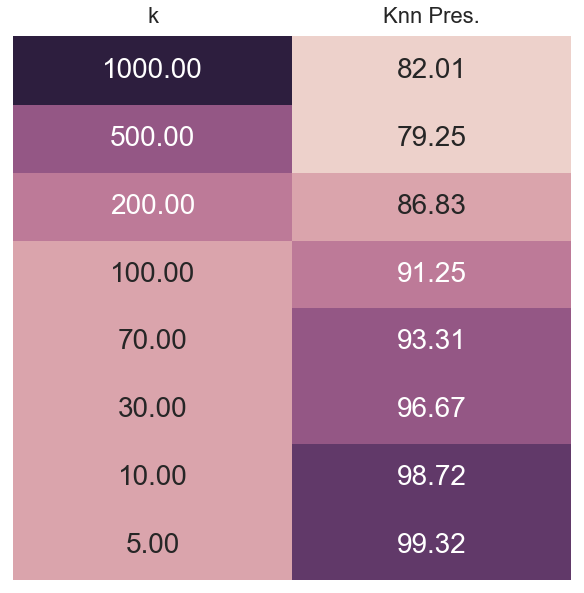

In [43]:
retina_norm=(retina_UMAP_sum-retina_UMAP_sum.mean())/retina_UMAP_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_UMAP_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/retina_UMAP_kNNtitration.png', transparent=True, bbox_inches='tight')

In [44]:
colon_PCA_sum = pd.DataFrame(final_kNN_stats['PCA']['colon'])
colon_PCA_sum = colon_PCA_sum.sort_values(by='k')
colon_PCA_sum = colon_PCA_sum.reindex(['k','Knn Pres.'], axis=1)
#colon_PCA_sum.to_csv('colon_PCA_kNNtitration.csv')

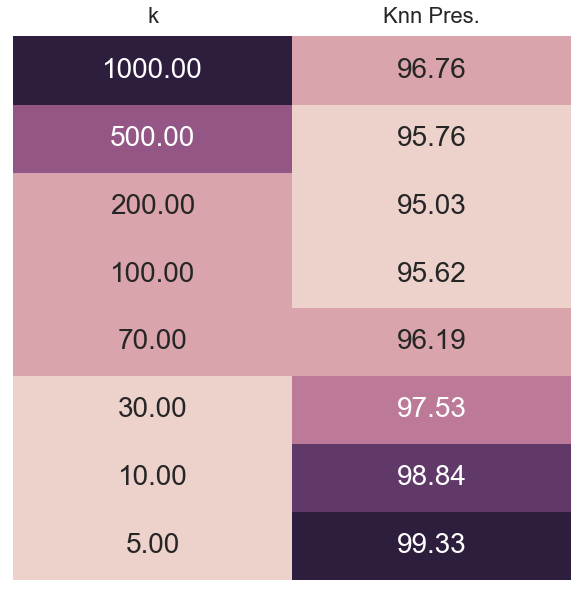

In [45]:
colon_norm=(colon_PCA_sum-colon_PCA_sum.mean())/colon_PCA_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_PCA_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/colon_PCA_kNNtitration.png', transparent=True, bbox_inches='tight')

In [46]:
colon_tSNE_sum = pd.DataFrame(final_kNN_stats['t-SNE']['colon'])
colon_tSNE_sum = colon_tSNE_sum.sort_values(by='k')
colon_tSNE_sum = colon_tSNE_sum.reindex(['k','Knn Pres.'], axis=1)
#colon_tSNE_sum.to_csv('colon_tSNE_kNNtitration.csv')

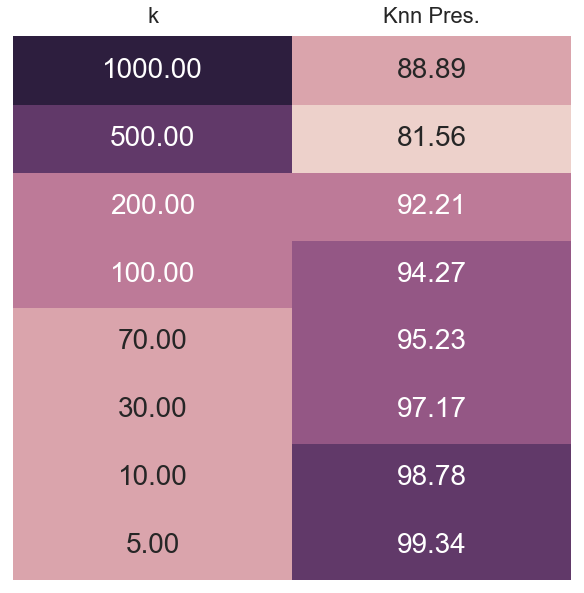

In [47]:
colon_norm=(colon_tSNE_sum-colon_tSNE_sum.mean())/colon_tSNE_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_tSNE_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/colon_tSNE_kNNtitration.png', transparent=True, bbox_inches='tight')

In [48]:
colon_UMAP_sum = pd.DataFrame(final_kNN_stats['UMAP']['colon'])
colon_UMAP_sum = colon_UMAP_sum.sort_values(by='k')
colon_UMAP_sum = colon_UMAP_sum.reindex(['k','Knn Pres.'], axis=1)
#colon_tSNE_sum.to_csv('colon_UMAP_kNNtitration.csv')

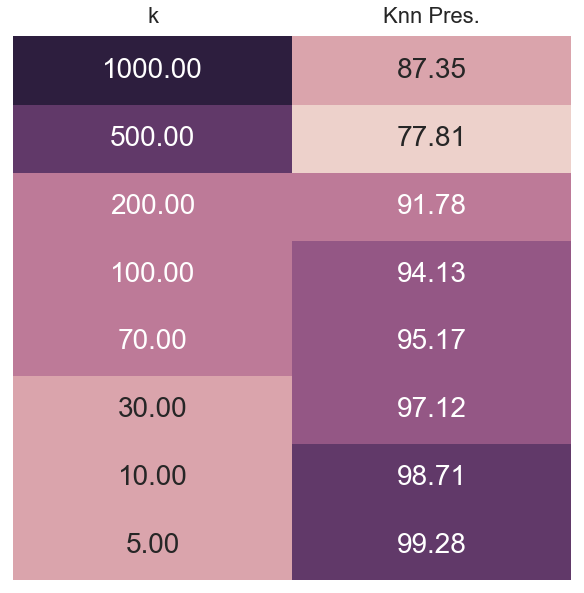

In [49]:
colon_norm=(colon_UMAP_sum-colon_UMAP_sum.mean())/colon_UMAP_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_UMAP_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False, yticklabels=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
#plt.savefig(fname='../images/colon_UMAP_kNNtitration.png', transparent=True, bbox_inches='tight')

In [50]:
retina_PCA_sum.set_index('k', drop=True, inplace=True)
retina_PCA_sum.rename(columns={'Knn Pres.':'Retina PCA'}, inplace=True)
retina_tSNE_sum.set_index('k', drop=True, inplace=True)
retina_tSNE_sum.rename(columns={'Knn Pres.':'Retina t-SNE'}, inplace=True)
retina_UMAP_sum.set_index('k', drop=True, inplace=True)
retina_UMAP_sum.rename(columns={'Knn Pres.':'Retina UMAP'}, inplace=True)

colon_PCA_sum.set_index('k', drop=True, inplace=True)
colon_PCA_sum.rename(columns={'Knn Pres.':'Colon PCA'}, inplace=True)
colon_tSNE_sum.set_index('k', drop=True, inplace=True)
colon_tSNE_sum.rename(columns={'Knn Pres.':'Colon t-SNE'}, inplace=True)
colon_UMAP_sum.set_index('k', drop=True, inplace=True)
colon_UMAP_sum.rename(columns={'Knn Pres.':'Colon UMAP'}, inplace=True)

In [51]:
from functools import reduce

In [52]:
df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), 
                   [retina_PCA_sum, retina_tSNE_sum, retina_UMAP_sum, colon_PCA_sum, colon_tSNE_sum, colon_UMAP_sum])

In [53]:
df_merged.index = df_merged.index.astype('str')

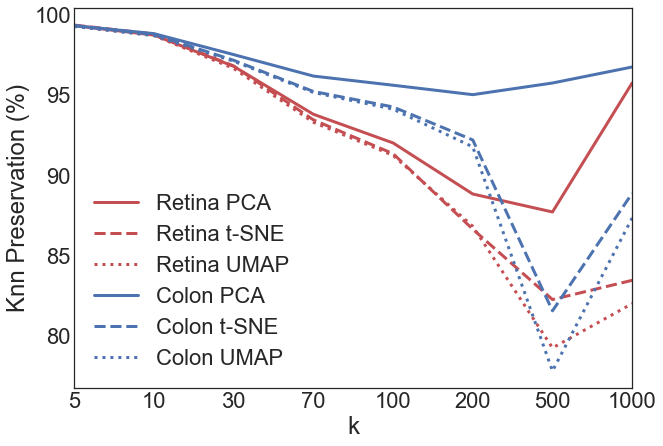

In [57]:
styles=['r-', 'r--', 'r:', 'b-', 'b--', 'b:']
with plt.style.context('seaborn-white'):
    df_merged.plot(figsize=(10,7), linewidth=3, style=styles)
    plt.ylabel('Knn Preservation (%)')
    plt.savefig('outputs/Knn_titration.png', dpi=1000)

In [56]:
df_merged.to_csv('outputs/Knn_titration.csv', header=True, index=True)